#智能床睡眠分期

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.font_manager import FontProperties
import pandas as pd
import os

In [2]:
# 设置中文字体路径
font_path = '../data/SimHei.ttf'
prop = FontProperties(fname=font_path, size=16)


In [3]:
def compute_minutes(x1, x2):
    '''
    计算两个时间戳之间的时间差（分钟）。

    该函数将两个时间戳字符串转换为日期时间对象，计算它们之间的时间差，并返回时间差（分钟）。

    参数:
        x1 (str): 第一个时间戳字符串，格式为 '%Y-%m-%d %H:%M:%S'。
        x2 (str): 第二个时间戳字符串，格式为 '%Y-%m-%d %H:%M:%S'。

    返回:
        int: 两个时间戳之间的时间差，以分钟为单位。
    '''
    # 将时间戳字符串转换为日期时间对象
    timestamp1_obj = datetime.strptime(x1, '%Y-%m-%d %H:%M:%S')
    timestamp2_obj = datetime.strptime(x2, '%Y-%m-%d %H:%M:%S')
    
    # 计算两个日期时间对象之间的时间差
    time_difference = timestamp1_obj - timestamp2_obj
    
    # 将时间差转换为分钟
    minutes_difference = time_difference.total_seconds() // 60
    
    # 返回分钟差值
    return int(minutes_difference)

In [4]:
def convert_to_hours_minutes(total_minutes):
    '''
    将总分钟数转换为小时和分钟。

    该函数将输入的总分钟数转换为小时和分钟的形式，便于更易读的时间表示。

    参数:
        total_minutes (int): 总分钟数。

    返回:
        tuple: 包含两个元素的元组:
            - hours (int): 计算得到的小时数。
            - minutes (int): 计算得到的分钟数。
    '''
    # 计算小时数，使用整数除法
    hours = total_minutes // 60
    # 计算剩余的分钟数
    minutes = total_minutes % 60
    
    # 返回小时和分钟
    return hours, minutes


In [5]:
def plot_sleep_data(file_path,save_path):
    '''
    从CSV文件读取睡眠数据并绘制睡眠阶段图表。

    该函数读取指定路径的CSV文件，提取睡眠阶段数据和相关信息，并绘制图表以显示睡眠阶段的时间分布。

    参数:
        file_path (str): 包含睡眠数据的CSV文件的路径。
    '''
    # 读取CSV数据文件
    df = pd.read_csv(file_path)

    # 提取相关数据列
    sleep_stage_data = df["col_sleep_stage"][0]  # 睡眠阶段数据
    shallow_sleep_duration = df["col_shallow_sleep_duration"][0]  # 浅睡时长
    deep_sleep_duration = df["col_deep_sleep_duration"][0]  # 深睡时长
    total_sleep_duration = df["col_sleep_duration"][0]  # 睡眠总时长
    avg_heart_rate = df["col_avg_heart_rate"][0]  # 平均心率
    clear_duration = df["col_clear_duration"][0]  # 清醒时长
    left_bed_duration = df["col_left_bed_duration"][0]  # 离床时长

    # 分割睡眠阶段数据
    text = sleep_stage_data.split(",")

    list_time = []
    list_value = []

    # 提取时间戳和睡眠阶段值
    for i in range(len(text) - 1):
        timestamp = text[i][:-2]
        stage_value = text[i][-1]
        list_time.append(timestamp)
        list_value.append(stage_value)

    # 根据时间戳计算各阶段持续时间并填充阶段值
    stages = []
    for i in range(1, len(list_time)):
        x1 = list_time[i]
        x2 = list_time[i - 1]
        duration = compute_minutes(x1, x2)
        stages.append(int(list_value[i - 1]) + 1)
        for j in range(duration - 1):
            stages.append(int(list_value[i - 1]) + 1)

    # 阶段映射：'清醒' -> 3, '深睡' -> 1, '潜睡' -> 2, '离床' -> 4
    stages_mapped = [3 if x == 1 else 1 if x == 2 else 2 if x == 3 else 4 for x in stages]
    stages_mapped = stages_mapped[:-59]
    colors = ['purple', 'r', 'pink', 'y']

    # 创建绘图区域
    plt.figure(figsize=(20, 7))

    current_stage = stages_mapped[0]
    start_idx = 0

    # 绘制睡眠阶段的色块
    for i in range(1, len(stages_mapped)):
        if stages_mapped[i] != current_stage:
            plt.fill_between(range(start_idx, i), [current_stage - 1] * (i - start_idx), [current_stage] * (i - start_idx), color=colors[current_stage - 1], step="pre")
            start_idx = i
            current_stage = stages_mapped[i]

    plt.fill_between(range(start_idx, len(stages_mapped)), [current_stage - 1] * (len(stages_mapped) - start_idx), [current_stage] * (len(stages_mapped) - start_idx), color=colors[current_stage - 1], step="pre")

    # 转换总睡眠时间为小时和分钟
    hours, minutes = convert_to_hours_minutes(total_sleep_duration)

    # 设置图表标题和标签
    plt.title(f'智能床睡眠分期结果\n 总睡眠时间：{hours}小时{minutes}分钟 深睡时间：{deep_sleep_duration}分钟 潜睡时间：{shallow_sleep_duration}分钟 清醒时间：{clear_duration}分钟 离床时间：{left_bed_duration}分钟', fontproperties=prop)
    plt.xlabel('时间', fontproperties=prop)
    plt.ylabel('阶段', fontproperties=prop)

    # 设置 y 轴和 x 轴刻度
    plt.yticks([1, 2, 3, 4], ['深睡', '潜睡', '清醒', '离床'], fontproperties=prop)
    plt.xticks([0, len(stages_mapped)], [list_time[0], "2024-06-30 06:07:00"], rotation=5, ha='right', va='top', fontproperties=prop)

    # 保存并显示图像
    plt.savefig(save_path)
    plt.show()


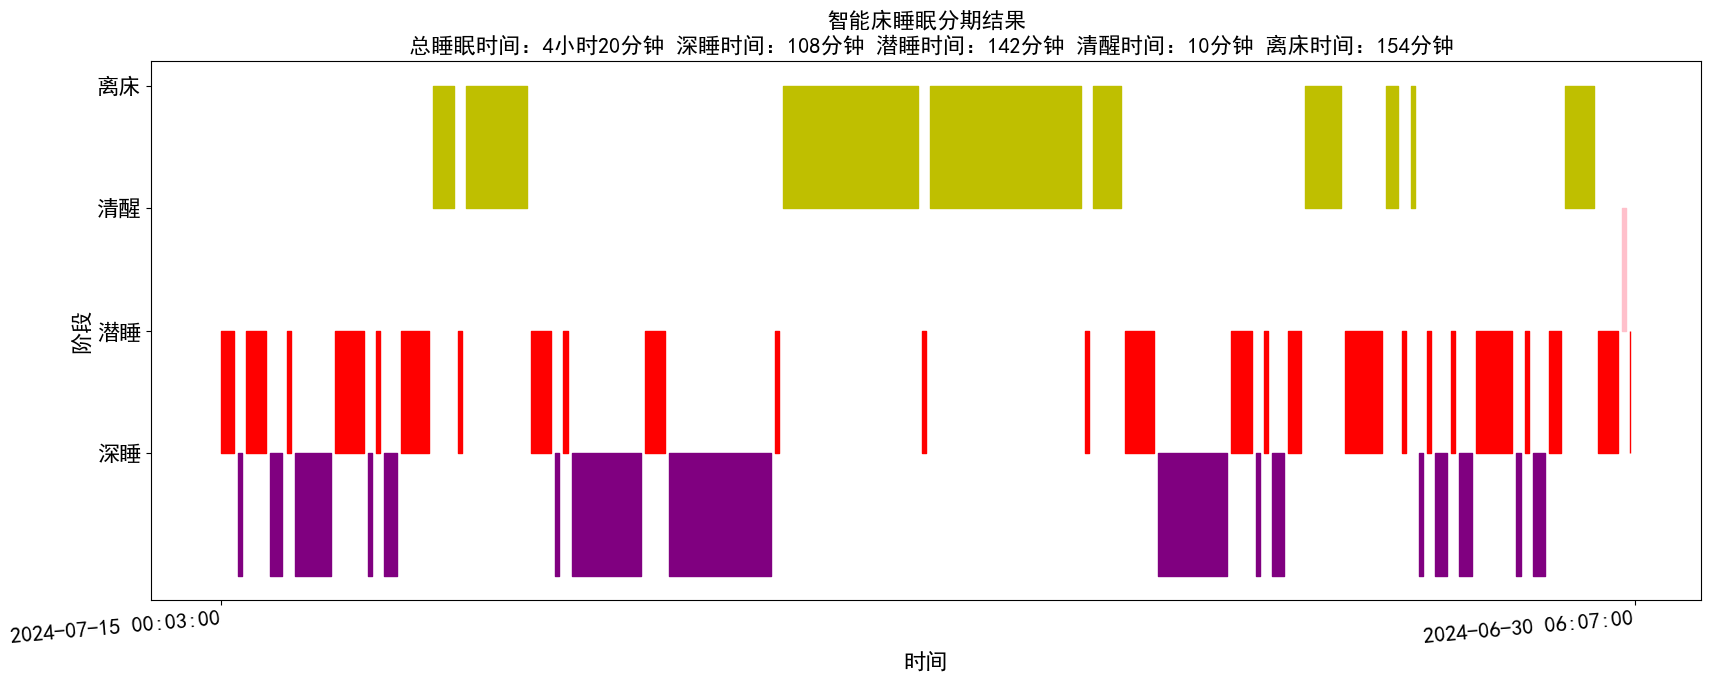

In [6]:
if __name__ == "__main__":
    file_path = "../data/Smart_bed_Sleep_log.csv"
    save_path = "../result/智能床睡眠分期.png"
    plot_sleep_data(file_path,save_path)